This model runs a final GridSearch to find the optimal number of blocks and evaluates the final model resulting from this GridSearch.

In [2]:
import numpy as np
import matplotlib.pyplot as plt #for displaying plots
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers
from keras.utils import plot_model

from tensorflow.keras.saving import register_keras_serializable

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import datetime
import random
import properscoring as ps

from scipy.stats import norm
from scikeras.wrappers import KerasRegressor

import xgboost
import pydot
import graphviz

from keras.models import load_model
from sklearn.multioutput import MultiOutputRegressor
import pickle

from sklearn.model_selection import ParameterGrid
from pathlib import Path
import joblib
import shap
from sklearn.model_selection import cross_val_score
from scipy import stats
import os

# Setup

In [3]:
# setting a seed to ensure reproducability and consistency
random.seed(16)
np.random.seed(16)
tf.random.set_seed(16)

In [4]:
# Change Working Directory
os.chdir("..")
print(os.getcwd()) # print current working directory

c:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Probabilistic-Forecasting-of-Bicycle-Counts-in-Karlsruhe-with-Neural-Networks


In [5]:
plt.rcParams.update({'font.size': 14})
sns.set_context("notebook", font_scale=1.4, rc={"axes.linewidth": 0.8, "lines.linewidth": 1})


In [6]:
X_train = pd.read_pickle(r"data\X_train_final.pkl")
X_valid = pd.read_pickle(r"data\X_valid_final.pkl")
X_test = pd.read_pickle(r"data\X_test_final.pkl")

X_train_all = pd.read_pickle(r"data\X_train.pkl")
X_valid_all = pd.read_pickle(r"data\X_valid.pkl")
X_test_all = pd.read_pickle(r"data\X_test.pkl")

y_train = pd.read_pickle(r"data\y_train_final.pkl")
y_valid = pd.read_pickle(r"data\y_valid_final.pkl")
y_test = pd.read_pickle(r"data\y_test_final.pkl")

In [7]:
X_train_all['date'] =  pd.to_datetime(X_train_all['date'])
X_valid_all['date'] =  pd.to_datetime(X_valid_all['date'])
X_test_all['date'] =  pd.to_datetime(X_test_all['date'])

In [7]:
X_train_all.head()

,date,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,2012-04-25,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,No Holiday,0,No Holiday,0,0,1,0,2
1,2012-04-26,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,No Holiday,0,No Holiday,0,0,1,0,3
2,2012-04-27,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,No Holiday,0,No Holiday,0,0,1,0,4
3,2012-04-28,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,No Holiday,0,No Holiday,0,0,0,0,5
4,2012-04-29,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,No Holiday,0,No Holiday,0,0,0,0,6


In [8]:
X_train_all.shape

(3161, 18)

In [9]:
X_train.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,-0.039776,-0.397192,0,1,2,1.0,0.0,0.0,0.0,-0.218119,-0.031329,0
1,0.244625,-0.397192,0,1,3,1.0,0.0,0.0,0.0,-0.324284,-0.458165,0
2,0.381694,-0.371451,0,1,4,1.0,0.0,0.0,0.0,-1.076810,0.254435,0
3,1.300863,-0.397192,0,0,5,1.0,0.0,0.0,0.0,-0.405469,1.357699,0
4,0.745990,0.555250,0,0,6,1.0,0.0,0.0,0.0,0.297096,0.059103,0


In [10]:
X_valid.tail()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
359,-1.064496,-0.397192,0,1,1,0.0,0.0,0.0,1.0,-0.258711,-0.353265,1
360,-0.478837,-0.397192,0,1,2,0.0,0.0,0.0,1.0,1.087091,-0.823509,1
361,-0.104279,0.143383,0,1,3,0.0,0.0,0.0,1.0,2.276769,-0.913940,1
362,-0.691404,0.169125,0,1,4,0.0,0.0,0.0,1.0,-0.674006,-0.508807,1
363,0.541485,-0.397192,0,0,5,0.0,0.0,0.0,1.0,1.564836,-0.201340,1


In [11]:
y_test.head()

0    1160.0
1    2996.0
2    3635.0
3    3265.0
4    3751.0
Name: bike_count, dtype: float64

In [12]:
X_train.shape, X_valid.shape, X_test.shape

((3161, 12), (364, 12), (390, 12))

In [13]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [14]:
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [15]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [16]:
X_train.isna().sum()

temperature                 0
precipitation               0
public_holiday_indicator    0
is_workday                  0
day_of_week                 0
spring                      0
summer                      0
autumn                      0
winter                      0
windspeed                   0
sun                         0
school_holiday_indicator    0
dtype: int64

In [17]:
X_train.dtypes

temperature                 float64
precipitation               float64
public_holiday_indicator      int64
is_workday                    int64
day_of_week                   int64
spring                      float64
summer                      float64
autumn                      float64
winter                      float64
windspeed                   float64
sun                         float64
school_holiday_indicator      int64
dtype: object

In [18]:
X_train.describe()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
count,3.161000e+03,3.161000e+03,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3.161000e+03,3.161000e+03,3161.000000
mean,4.450726e-16,3.708939e-17,0.033534,0.684910,3.001898,0.243277,0.259412,0.259095,0.238216,4.832859e-17,4.720467e-17,0.232521
std,1.000158e+00,1.000158e+00,0.180054,0.464625,2.001106,0.429129,0.438381,0.438207,0.426059,1.000158e+00,1.000158e+00,0.422506
min,-2.660948e+00,-3.971923e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.513961e+00,-1.094803e+00,0.000000
25%,-7.932892e-01,-3.971923e-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-7.364558e-01,-9.899026e-01,0.000000
50%,-9.270793e-04,-3.971923e-01,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-2.056287e-01,-2.085744e-01,0.000000
75%,7.907021e-01,-1.140338e-01,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,0.000000,4.969366e-01,8.585175e-01,0.000000
max,2.566737e+00,1.461021e+01,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,4.952762e+00,2.193287e+00,1.000000


# Functions

In [19]:
def add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, col_name):
    
    X_train_num[col_name] = X_train[col_name]
    X_valid_num[col_name] = X_valid[col_name]
    X_test_num[col_name] = X_test[col_name]
    
    return X_train_num, X_valid_num, X_test_num

In [20]:
def crps_normal_cost_function(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]
    
    # Split input
    mu = y_pred[:, 0]
    var = tf.square(y_pred[:, 1]) # Ensure standard deviation is positive
    sigma = tf.sqrt(var)  
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [21]:
def crps_normal_cost_function_v2(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]

    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [18]:
def predict_and_calculate_mean_crps(model, X_test = X_test, y_test = y_test, print_predicted_mean_std = False):
    """Make predictions on test data and calculate mean CRPS.

    Args:
        model: Trained model
        X_test: Test data
        y_test: True values
        print_predicted_mean_std: Boolean to print predicted mean and std

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
     
    predicted_mean_std = model.predict(X_test)
    if print_predicted_mean_std:
        print(predicted_mean_std)
    
    predicted_mean = predicted_mean_std[:, 0]
    predicted_std = predicted_mean_std[:, 1]
    crps_values = ps.crps_gaussian(y_test, mu=predicted_mean, sig=predicted_std)

    mean_crps = np.mean(crps_values)
    print(f"\nMean CRPS: { mean_crps }")


    return mean_crps, predicted_mean_std, crps_values

In [23]:
def compile_and_fit_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10):
    """Compile and fit a model on training data.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size

    Returns:
        model: Trained model
    """

    #print some information about the model
    print('Model information:\n\nCallbacks: EarlyStopping (patience: ' + str(pat) + '), Learning Rate (Reduce on Plateau, patience: ' + str(pat) + ')\nBatch size: ' + str(batch_size) + '\nEpochs: ' + str(epochs) + '\n')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=pat, 
                                                      restore_best_weights=True)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience = pat,
                                                     min_lr=0 )
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_function)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[early_stopping, reduce_lr])

    return model, history

In [24]:
def plot_loss(history):
    """Plot training and validation loss.

    Args:
        history: History object
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [25]:
def process_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  X_test = X_test, y_test = y_test, pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10, print_predicted_mean_std = False, plot_loss_flag = True):
    """Compile, fit and evaluate a model.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        X_test: Test data
        y_test: Test targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size
        print_predicted_mean_std: Boolean to print predicted mean and std
"""

    model, history = compile_and_fit_model(model, X_train, y_train, X_valid, y_valid,  pat, lr, loss_function, epochs, batch_size)

    mean_crps, predicted_mean_std = predict_and_calculate_mean_crps(model, X_test, y_test, print_predicted_mean_std)

    if plot_loss_flag:
        plot_loss(history)

    return model, mean_crps, history, predicted_mean_std

In [26]:
X_train_all.head()

,date,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,2012-04-25,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,No Holiday,0,No Holiday,0,0,1,0,2
1,2012-04-26,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,No Holiday,0,No Holiday,0,0,1,0,3
2,2012-04-27,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,No Holiday,0,No Holiday,0,0,1,0,4
3,2012-04-28,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,No Holiday,0,No Holiday,0,0,0,0,5
4,2012-04-29,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,No Holiday,0,No Holiday,0,0,0,0,6


In [27]:
X_train.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,-0.039776,-0.397192,0,1,2,1.0,0.0,0.0,0.0,-0.218119,-0.031329,0
1,0.244625,-0.397192,0,1,3,1.0,0.0,0.0,0.0,-0.324284,-0.458165,0
2,0.381694,-0.371451,0,1,4,1.0,0.0,0.0,0.0,-1.076810,0.254435,0
3,1.300863,-0.397192,0,0,5,1.0,0.0,0.0,0.0,-0.405469,1.357699,0
4,0.745990,0.555250,0,0,6,1.0,0.0,0.0,0.0,0.297096,0.059103,0


In [28]:
X_test.tail()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
385,-1.826072,-0.397192,0,0,6,0.0,0.0,0.0,1.0,-1.030753,-0.403906,0
386,-0.641377,0.992859,0,1,0,0.0,0.0,0.0,1.0,2.053509,-1.094803,0
387,-0.525381,-0.268484,0,1,1,0.0,0.0,0.0,1.0,2.151868,-0.501572,0
388,-0.052053,0.091900,0,1,2,0.0,0.0,0.0,1.0,2.770125,-1.069482,0
389,-0.392344,-0.139775,0,1,3,0.0,0.0,0.0,1.0,-0.042477,-0.299006,0


# Hyperparameter Tuning

## Functions

In [12]:
@register_keras_serializable(package="Custom", name="crps_normal_cost_function")
def crps_normal_cost_function_v3(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    #print("y_true shape2: ", y_true.shape)
    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]
    
    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    
     # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))   
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps


In [13]:
@register_keras_serializable(package="Custom", name="crps_loss_function_wrapper")  
def crps_loss_function_wrapper(y_true, y_pred, tensor=True):
    """Wrapper for CRPS loss function.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """
    
    if isinstance(y_pred, (pd.DataFrame, pd.Series)):
       y_pred = tf.convert_to_tensor(y_pred.values)

    if isinstance(y_true, (pd.DataFrame, pd.Series)):
        y_true = tf.convert_to_tensor(y_true.values, dtype=tf.float32)
        
    y_pred_reshaped = y_pred.reshape(-1, 2) #Keras Regressor flattens the values so they need to be reshaped

    crps = crps_normal_cost_function_v3(y_true, y_pred_reshaped, tensor)

    crps = crps.numpy()
    
    return crps

In [31]:

def tune_nn(input_shape_in, X_train_in, X_valid_in, X_test_in, y_train_in, y_valid_in, y_test_in, model_in=None, n_neurons=[256], dropout_rate=[0.25], 
            reg_values=[0.01], batch_size=[32], learning_rate=[1e-4], n_blocks=[2,4,5,6], epochs = 200, cv=5, n_jobs=1, verbose=10, patience=5):
    """Tune hyperparameters of a neural network using GridSearchCV.

    Args:
        input_shape_in: Number of features
        X_train_in: Training data
        X_valid_in: Validation data
        X_test_in: Test data
        y_train_in: Training targets
        y_valid_in: Validation targets
        y_test_in: Test targets
        model_in: Predefined model
        n_neurons: Number of neurons in hidden layers
        dropout_rate: Dropout rate
        reg_values: Regularization values
        batch_size: Batch size
        learning_rate: Learning rate
        n_blocks: Number of blocks
        epochs: Number of epochs
        cv: Number of cross-validation folds
        n_jobs: Number of jobs
        verbose: Verbosity
        patience: Patience for early stopping


    Returns:
        y_pred: Predictions on test data
        best_model: Best model
        cv_results: Results of cross-validation
    """


    iteration = 0

    # Define Keras model with hyperparameters
    def create_model(n_neurons, dropout_rate, reg_value, n_blocks):
        nonlocal iteration  # Declare iteration as nonlocal
        model = model_in
        input_shape = input_shape_in
        if model is None:
            model = Sequential()
            model.add(Input(shape=(input_shape,)))

            for i in range(n_blocks):
                model.add(Dense(n_neurons, activation='relu', kernel_regularizer=regularizers.l2(reg_value)))
                model.add(Dropout(dropout_rate))
            
            # Output layer with two outputs: mean and std
            model.add(Dense(2, activation='softplus'))
        
        if iteration % cv == 1 or iteration == 0: # don't print for every fold
            model.summary()
        
        iteration += 1
        # only to see that something is happening
        print("Iteration: " + str(iteration))

        
        model.compile(optimizer=tf.keras.optimizers.Adam(), loss=crps_normal_cost_function_v3 )
        return model

    # Define hyperparameters
    param_grid = dict(
       batch_size=batch_size,
       optimizer__learning_rate=learning_rate,
        model__n_neurons=n_neurons,
        model__dropout_rate=dropout_rate,
        model__reg_value=reg_values,
        model__n_blocks=n_blocks
    ) 


    # Create the model
    model = KerasRegressor(model=create_model, epochs=epochs, verbose=0)
    

    my_scorer = make_scorer(crps_loss_function_wrapper, greater_is_better=False) 

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=my_scorer)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    grid_search.fit(X_train_in, y_train_in, validation_data=(X_valid_in, y_valid_in), callbacks=[early_stopping])

    # Access the best hyperparameters and results
    best_params = grid_search.best_params_
    cv_results = pd.DataFrame(grid_search.cv_results_)
    best_model = grid_search.best_estimator_

    # Print the best hyperparameters
    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    y_pred = best_model.model_.predict(X_test_in)
    predicted_mean = y_pred[:, 0]
    predicted_std = y_pred[:, 1]

    mean_crps = np.mean(ps.crps_gaussian(y_test_in, mu=predicted_mean, sig=predicted_std))
    print(f"\nMean CRPS: { mean_crps }")
    
    return  y_pred, best_model, cv_results, grid_search

## Grid Search

### Test 1
Checking if 4 is actually the best value for number of blocks.

In [32]:
y_pred_tuned1, best_model_tuned1, cv_results_tuned1, grid_search_tuned1 = tune_nn(X_train.shape[1], X_train, X_valid, X_test, y_train, y_valid, y_test, cv=3, n_neurons=[128],
            reg_values=[0.01], learning_rate=[1e-4] )

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=2, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,434 (72.01 KB)

 Trainable params: 18,434 (72.01 KB)

 Non-trainable params: 0 (0.00 B)

Iteration: 1
[CV 1/3; 1/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=2, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-447.996 total time= 1.3min
[CV 2/3; 1/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=2, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,434 (72.01 KB)

 Trainable params: 18,434 (72.01 KB)

 Non-trainable params: 0 (0.00 B)

Iteration: 2
[CV 2/3; 1/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=2, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-393.964 total time= 1.4min
[CV 3/3; 1/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=2, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 3
[CV 3/3; 1/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=2, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-478.433 total time= 1.6min
[CV 1/3; 2/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=4, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 4
[CV 1/3; 2/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=4, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-409.770 total time= 1.7min
[CV 2/3; 2/4] START batch_size=32, model__dropout_rate=0.25, model__n_bloc

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,458 (201.01 KB)

 Trainable params: 51,458 (201.01 KB)

 Non-trainable params: 0 (0.00 B)

Iteration: 5
[CV 2/3; 2/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=4, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-356.428 total time= 1.7min
[CV 3/3; 2/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=4, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 6
[CV 3/3; 2/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=4, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-429.208 total time= 1.7min
[CV 1/3; 3/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=5, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 7
[CV 1/3; 3/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=5, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-385.525 total time= 1.9min
[CV 2/3; 3/4] START batch_size=32, model__dropout_rate=0.25, model__n_bloc

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,970 (265.51 KB)

 Trainable params: 67,970 (265.51 KB)

 Non-trainable params: 0 (0.00 B)

Iteration: 8
[CV 2/3; 3/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=5, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-370.724 total time= 2.3min
[CV 3/3; 3/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=5, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 9
[CV 3/3; 3/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=5, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-442.488 total time= 2.1min
[CV 1/3; 4/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=6, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 10
[CV 1/3; 4/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=6, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-424.271 total time= 2.0min
[CV 2/3; 4/4] START batch_size=32, model__dropout_rate=0.25, model__n_blo

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,482 (330.01 KB)

 Trainable params: 84,482 (330.01 KB)

 Non-trainable params: 0 (0.00 B)

Iteration: 11
[CV 2/3; 4/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=6, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-368.959 total time= 1.5min
[CV 3/3; 4/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=6, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 12
[CV 3/3; 4/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=6, model__n_neurons=128, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-443.053 total time= 1.4min
Iteration: 13
Best Hyperparameters:
batch_size: 32
model__dropout_rate: 0.25
model__n_blocks: 4
model__n_neurons: 128
model__reg_value: 0.01
optimizer__learning_rate: 0.0001
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Mean CRPS: 329.6166551764652


In [33]:
cv_results_tuned1['mean_test_score'] = -cv_results_tuned1['mean_test_score']

In [34]:
cv_results_tuned1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_model__dropout_rate,param_model__n_blocks,param_model__n_neurons,param_model__reg_value,param_optimizer__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,86.240228,8.517851,0.409509,0.095236,32,0.25,2,128,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-447.995941,-393.964203,-478.433136,440.131093,34.929854,4
1,101.159871,1.868226,0.389202,0.031387,32,0.25,4,128,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-409.770477,-356.427551,-429.208221,398.468750,30.768526,1
2,125.015147,8.494330,0.510621,0.084676,32,0.25,5,128,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-385.525421,-370.724243,-442.487610,399.579091,30.936757,2
3,99.333837,16.502977,0.411934,0.067951,32,0.25,6,128,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-424.271484,-368.958954,-443.053314,412.094584,31.450503,3


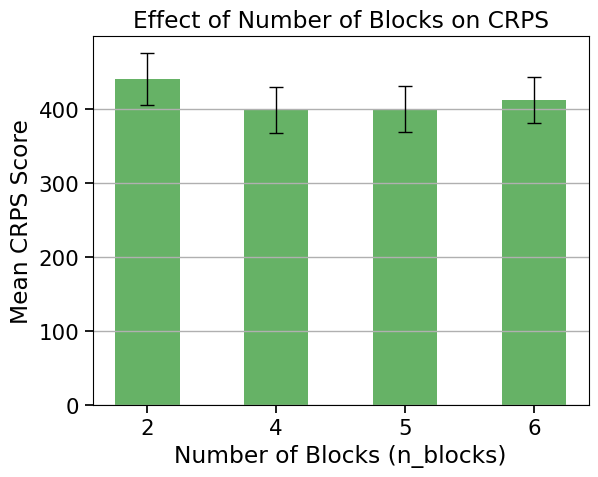

In [35]:
n_blocks_values = cv_results_tuned1['param_model__n_blocks'].unique()
mean_crps_n_blocks = [cv_results_tuned1[cv_results_tuned1['param_model__n_blocks'] == nb]['mean_test_score'].mean() for nb in n_blocks_values]
std_crps_n_blocks = [cv_results_tuned1[cv_results_tuned1['param_model__n_blocks'] == nb]['std_test_score'].mean() for nb in n_blocks_values]

bar_width = 0.4  
index = np.arange(len(n_blocks_values))  *0.8

plt.bar(index, mean_crps_n_blocks, yerr=std_crps_n_blocks, capsize=5, color='green', alpha=0.6, width=bar_width, label="n_blocks")

plt.title("Effect of Number of Blocks on CRPS")
plt.xlabel("Number of Blocks (n_blocks)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, n_blocks_values)  
plt.grid(True, axis='y')
plt.show()


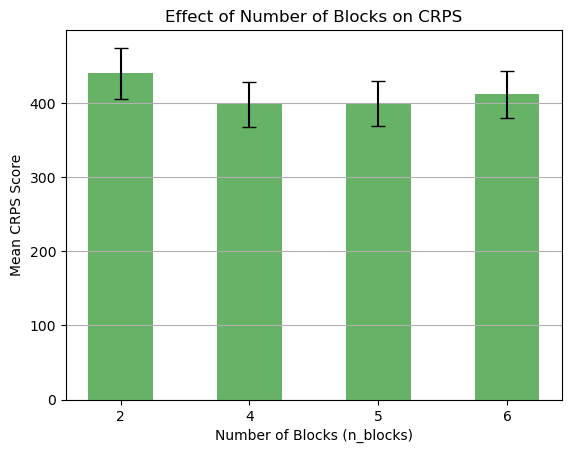

### Test 2
Checking if 4 is actually the best value for number of blocks, but with 256 neurons per layer.

In [37]:
y_pred_tuned, best_model_tuned, cv_results_tuned, grid_search_tuned = tune_nn(X_train.shape[1], X_train, X_valid, X_test, y_train, y_valid, y_test, cv=3 )

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=2, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_71 (Dense)                │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,634 (272.01 KB)

 Trainable params: 69,634 (272.01 KB)

 Non-trainable params: 0 (0.00 B)

Iteration: 1
[CV 1/3; 1/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=2, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-433.171 total time= 1.7min
[CV 2/3; 1/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=2, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_74 (Dense)                │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,634 (272.01 KB)

 Trainable params: 69,634 (272.01 KB)

 Non-trainable params: 0 (0.00 B)

Iteration: 2
[CV 2/3; 1/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=2, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-379.606 total time= 1.1min
[CV 3/3; 1/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=2, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 3
[CV 3/3; 1/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=2, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-467.654 total time= 1.1min
[CV 1/3; 2/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=4, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 4
[CV 1/3; 2/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=4, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-388.476 total time= 1.4min
[CV 2/3; 2/4] START batch_size=32, model__dropout_rate=0.25, model__n_bloc

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,218 (786.01 KB)

 Trainable params: 201,218 (786.01 KB)

 Non-trainable params: 0 (0.00 B)

Iteration: 5
[CV 2/3; 2/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=4, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-360.663 total time= 1.4min
[CV 3/3; 2/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=4, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 6
[CV 3/3; 2/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=4, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-446.991 total time= 1.4min
[CV 1/3; 3/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=5, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 7
[CV 1/3; 3/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=5, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-430.641 total time= 1.5min
[CV 2/3; 3/4] START batch_size=32, model__dropout_rate=0.25, model__n_bloc

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_101 (Dense)               │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,010 (1.02 MB)

 Trainable params: 267,010 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Iteration: 8
[CV 2/3; 3/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=5, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-370.927 total time= 1.6min
[CV 3/3; 3/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=5, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 9
[CV 3/3; 3/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=5, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-497.858 total time= 1.5min
[CV 1/3; 4/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=6, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 10
[CV 1/3; 4/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=6, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-416.935 total time= 1.7min
[CV 2/3; 4/4] START batch_size=32, model__dropout_rate=0.25, model__n_blo

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)               │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,802 (1.27 MB)

 Trainable params: 332,802 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Iteration: 11
[CV 2/3; 4/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=6, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-375.473 total time= 1.7min
[CV 3/3; 4/4] START batch_size=32, model__dropout_rate=0.25, model__n_blocks=6, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001
Iteration: 12
[CV 3/3; 4/4] END batch_size=32, model__dropout_rate=0.25, model__n_blocks=6, model__n_neurons=256, model__reg_value=0.01, optimizer__learning_rate=0.0001;, score=-527.740 total time= 1.7min
Iteration: 13
Best Hyperparameters:
batch_size: 32
model__dropout_rate: 0.25
model__n_blocks: 4
model__n_neurons: 256
model__reg_value: 0.01
optimizer__learning_rate: 0.0001
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Mean CRPS: 302.85038590421107


## Saving the GridSearch

In [9]:
base_path = Path(r"hyperparameter_tuning_results\Final_GridSearch")

In [10]:
file_name_grid_search = "grid_search_tuned_v3.pkl"
file_path_grid_search = base_path / file_name_grid_search

In [ ]:
joblib.dump(grid_search_tuned, str(file_path_grid_search))

['hyperparameter_tuning_results\\Final_GridSearch\\grid_search_tuned_v3.pkl']

## Loading the Grid Search

In [14]:
loaded_grid_search_tuned = joblib.load(str(file_path_grid_search))

In [41]:
loaded_grid_search_tuned.best_params_

{'batch_size': 32,
 'model__dropout_rate': 0.25,
 'model__n_blocks': 4,
 'model__n_neurons': 256,
 'model__reg_value': 0.01,
 'optimizer__learning_rate': 0.0001}

In [42]:
pd.DataFrame(loaded_grid_search_tuned.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_model__dropout_rate,param_model__n_blocks,param_model__n_neurons,param_model__reg_value,param_optimizer__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,78.204610,18.691333,0.313856,0.110598,32,0.25,2,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-433.170929,-379.605652,-467.654449,-426.810343,36.226054,2
1,82.485094,0.595056,0.311036,0.040606,32,0.25,4,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-388.475555,-360.662506,-446.990967,-398.709676,35.978732,1
2,92.725573,0.280839,0.355519,0.040057,32,0.25,5,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-430.640564,-370.926575,-497.857666,-433.141602,51.849570,3
3,102.334637,0.126687,0.345651,0.015663,32,0.25,6,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-416.934509,-375.472809,-527.739502,-440.048940,64.275419,4


In [43]:
loaded_grid_search_tuned.best_index_

1

In [20]:
model = loaded_grid_search_tuned.best_estimator_

In [45]:
model.model_.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_134 (Dense)               │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,656 (2.30 MB)

 Trainable params: 201,218 (786.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 402,438 (1.54 MB)

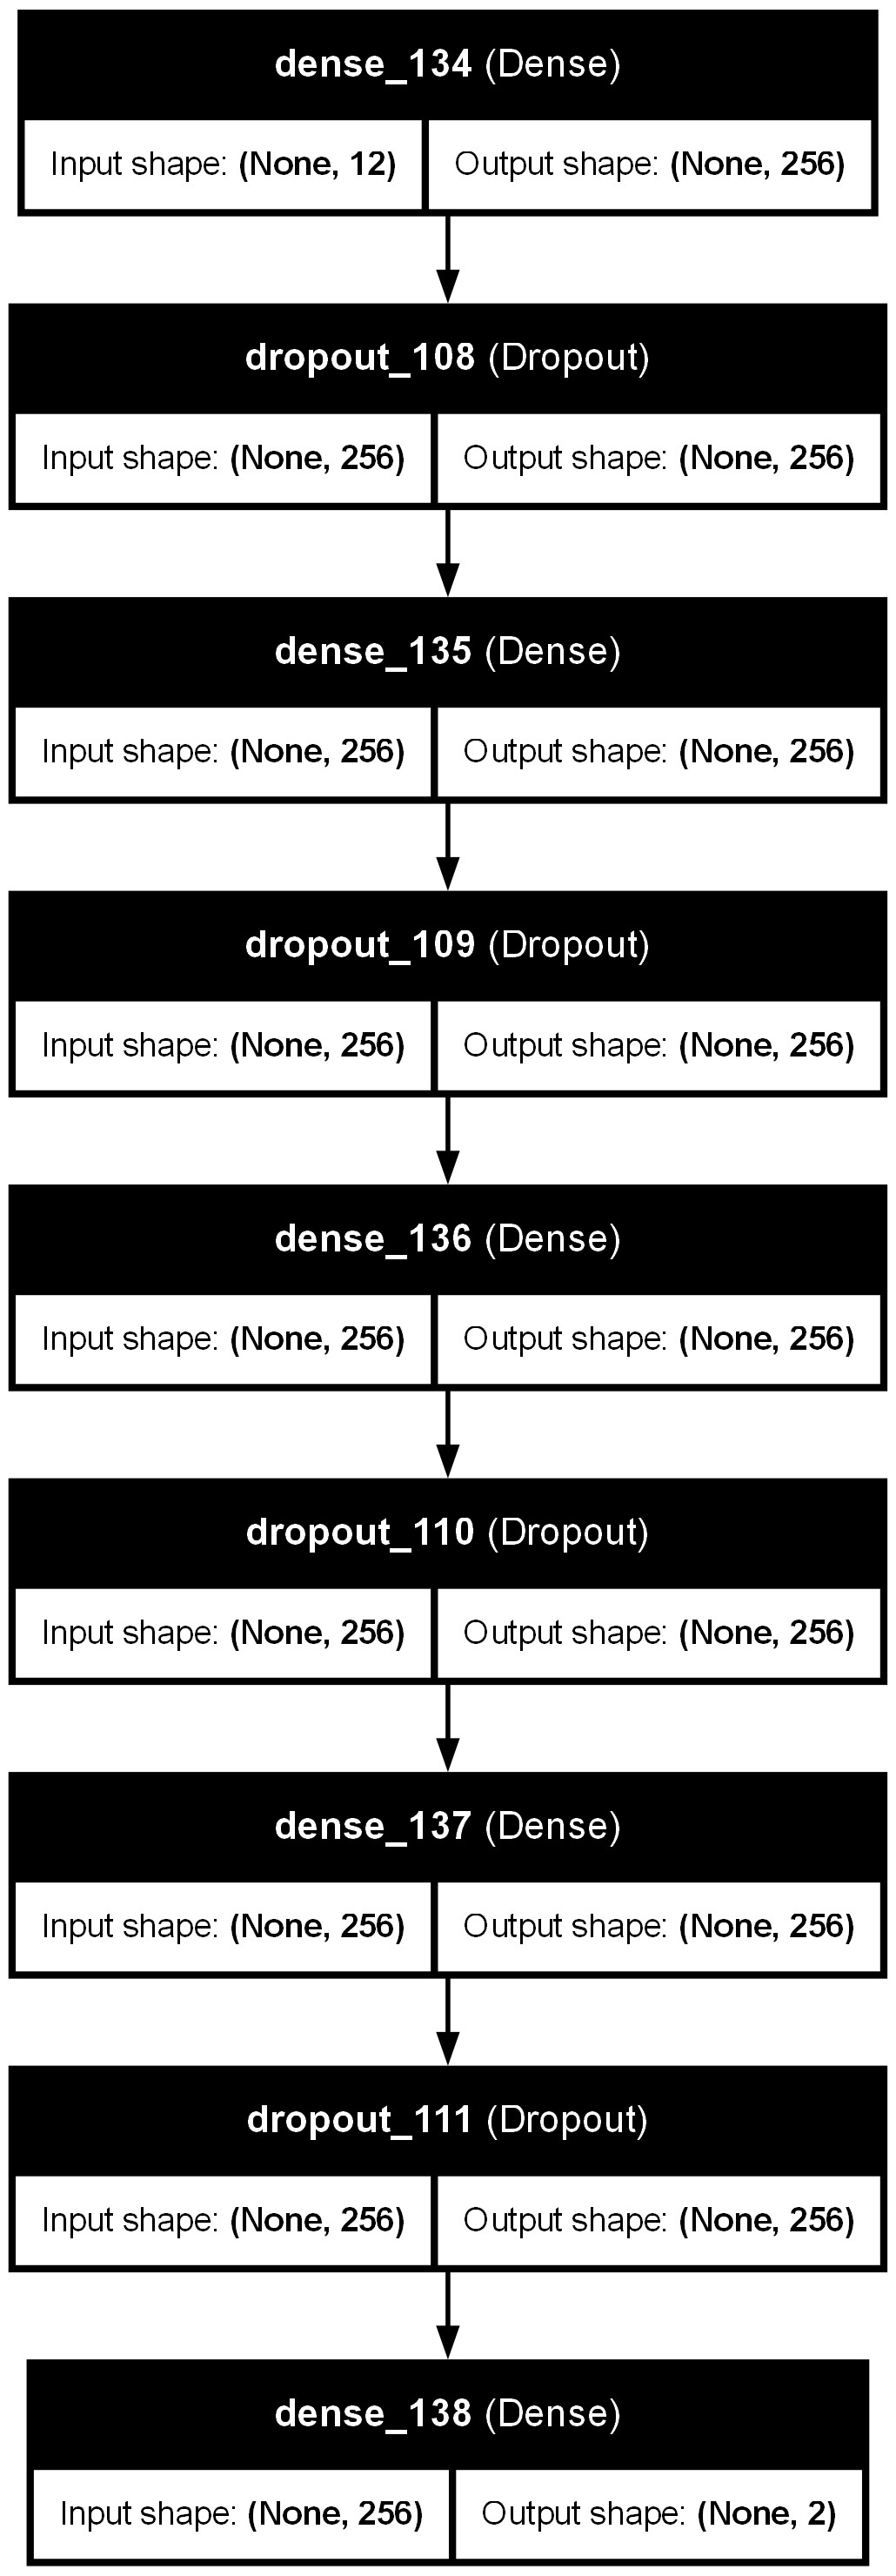

In [46]:
plot_model(model.model_, to_file=base_path / 'model_plot.png', show_shapes=True, show_layer_names=True)

In [47]:
loaded_grid_search_tuned.best_score_

-398.7096761067708

In [21]:
mean_crps, predicted_mean_std, crps_values = predict_and_calculate_mean_crps(model.model_, X_test, y_test, print_predicted_mean_std = False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Mean CRPS: 302.85038590421107


In [49]:
loaded_grid_search_tuned.scorer_

make_scorer(crps_loss_function_wrapper, greater_is_better=False, response_method='predict')

In [50]:
loaded_grid_search_tuned.n_splits_

3

In [51]:
model.model_.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_134 (Dense)               │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,656 (2.30 MB)

 Trainable params: 201,218 (786.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 402,438 (1.54 MB)

In [52]:
predicted_mean_std

array([[ 589.4193  ,  109.02333 ],
       [2436.3572  ,  352.0729  ],
       [2864.2546  ,  413.0073  ],
       [2474.3867  ,  357.39844 ],
       [2818.5908  ,  406.3799  ],
       [ 537.50366 ,  104.847626],
       [2266.575   ,  327.76132 ],
       [1137.4603  ,  219.74529 ],
       [3559.8438  ,  512.24567 ],
       [4701.029   ,  674.69904 ],
       [3550.6414  ,  510.7442  ],
       [4455.1084  ,  639.61804 ],
       [3368.7756  ,  484.88452 ],
       [2870.2415  ,  413.86206 ],
       [ 984.21344 ,  189.97183 ],
       [3408.6326  ,  490.70633 ],
       [4627.1753  ,  664.2306  ],
       [3981.6785  ,  572.18274 ],
       [3933.8643  ,  565.3196  ],
       [3924.8396  ,  564.1334  ],
       [2223.7478  ,  321.75803 ],
       [1144.897   ,  221.95357 ],
       [3696.8777  ,  531.7825  ],
       [3969.3914  ,  570.49884 ],
       [4059.7368  ,  583.29266 ],
       [4047.832   ,  581.5907  ],
       [3895.9873  ,  559.98535 ],
       [2622.644   ,  378.58673 ],
       [1298.6112  ,

In [53]:
y_pred_df = pd.DataFrame(predicted_mean_std)

In [54]:
y_pred_df.describe()

,0,1
count,390.000000,390.000000
mean,4367.300781,640.622437
std,1771.781494,238.070862
min,504.047852,97.418633
25%,2976.810120,472.008156
50%,4498.622070,646.130768
75%,5758.794800,825.839539
max,7789.466309,1115.376099


## Plots

### Residuals etc.

### Residuals

In [15]:
base_path_plots = Path(r"Figures\(15) Final_GridSearch")

In [22]:
predicted_mean = predicted_mean_std[:, 0]
predicted_std = predicted_mean_std[:, 1]

In [23]:
residuals = y_test - predicted_mean

In [58]:
file_name_residuals_hist = "residuals_hist.png"
file_path_residuals_hist = base_path_plots / file_name_residuals_hist

In [59]:
sum_residuals_negative = residuals[residuals < 0].sum()
sum_residuals_positive = residuals[residuals > 0].sum()

print("Sum of residuals smaller than zero:", sum_residuals_negative)
print("Sum of residuals larger than zero:", sum_residuals_positive)

Sum of residuals smaller than zero: -69428.57598876953
Sum of residuals larger than zero: 88547.4801740374


In [60]:
pd.DataFrame(predicted_std).describe()    

,0
count,390.000000
mean,640.622437
std,238.070862
min,97.418633
25%,472.008156
50%,646.130768
75%,825.839539
max,1115.376099


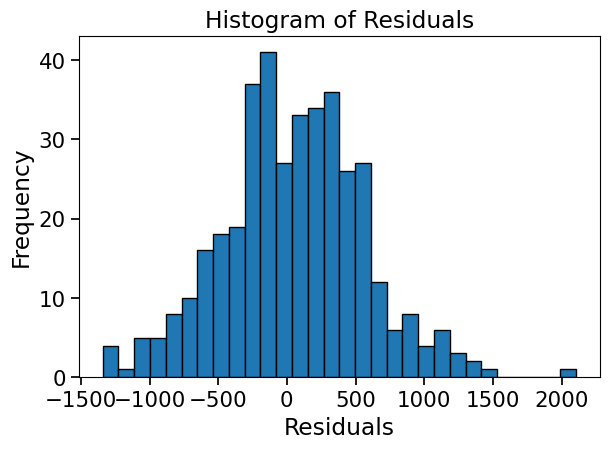

In [61]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.gcf().savefig(file_path_residuals_hist)
plt.show()


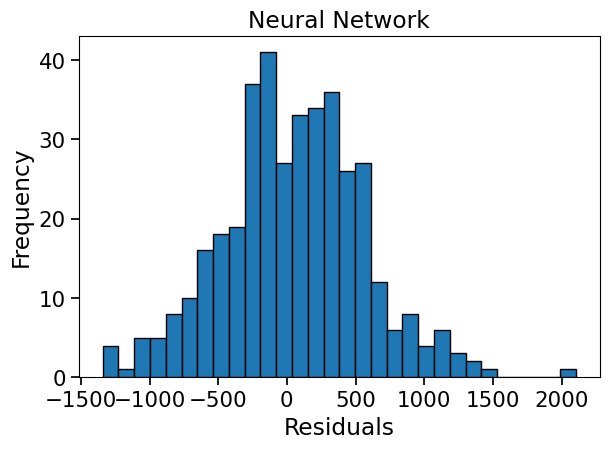

In [31]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Neural Network")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.gcf().savefig( base_path_plots / "residuals_hist_nn.png")
plt.show()

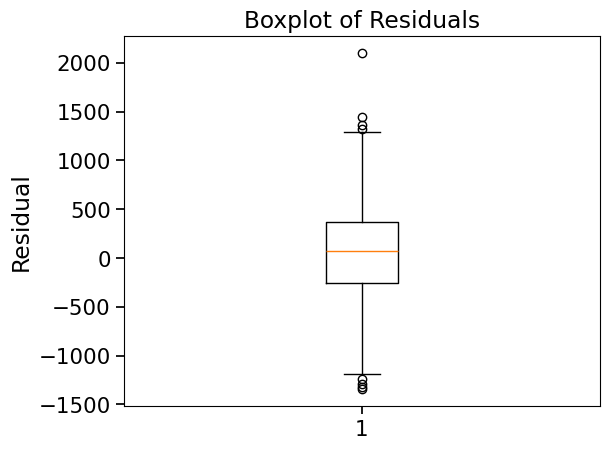

In [62]:
file_name_boxplot_residuals = "boxplot_residuals.png"
file_path_boxplot_residuals = base_path_plots / file_name_boxplot_residuals

boxplot_residuals = plt.boxplot(residuals)
plt.title("Boxplot of Residuals")
plt.ylabel("Residual")
plt.tight_layout()
plt.gcf().savefig(file_path_boxplot_residuals)
plt.show()

#### Residuals outlier analysis

In [63]:
residuals.describe()

count     390.000000
mean       49.022831
std       513.366506
min     -1341.895996
25%      -257.776123
50%        70.561523
75%       367.989746
max      2105.098877
Name: bike_count, dtype: float64

In [64]:
top_5_residuals = residuals.nlargest(5)
print(top_5_residuals)

353    2105.098877
86     1448.089355
352    1362.344727
6      1324.425049
356    1286.764648
Name: bike_count, dtype: float64


In [65]:
residuals[5]

1036.496337890625

In [66]:
X_test_all.iloc[353]

date                        2023-12-20 00:00:00
temperature                            -0.82774
humidity                                0.81555
windspeed                              1.910654
wind_direction                         0.716403
visibility                             0.312224
precipitation                          1.250275
sun                                   -0.852447
windspeed_max                          1.534996
precip_indic                                  1
school_holiday                       No Holiday
school_holiday_indicator                      0
public_holiday                       No Holiday
public_holiday_indicator                      0
holiday_indicator                             0
is_workday                                    1
season                                        3
day_of_week                                   2
Name: 353, dtype: object

#### More Residuals Plots

In [67]:
predicted_mean

array([ 589.4193 , 2436.3572 , 2864.2546 , 2474.3867 , 2818.5908 ,
        537.50366, 2266.575  , 1137.4603 , 3559.8438 , 4701.029  ,
       3550.6414 , 4455.1084 , 3368.7756 , 2870.2415 ,  984.21344,
       3408.6326 , 4627.1753 , 3981.6785 , 3933.8643 , 3924.8396 ,
       2223.7478 , 1144.897  , 3696.8777 , 3969.3914 , 4059.7368 ,
       4047.832  , 3895.9873 , 2622.644  , 1298.6112 , 3329.9565 ,
       3964.36   , 4088.3225 , 4422.6685 , 4237.8184 , 2917.2607 ,
       1082.6547 , 4257.5684 , 4147.528  , 4276.9136 , 4157.832  ,
       4336.602  , 3039.231  , 1573.8646 , 4711.3774 , 4277.5806 ,
       4338.213  , 4741.044  , 4583.2017 , 2997.5505 , 1340.0012 ,
       5081.1763 , 5193.896  , 4936.8613 , 4774.204  , 4736.834  ,
       2988.0596 , 1039.2888 , 3943.5105 , 4028.0076 , 4151.217  ,
       4437.9194 , 4555.226  , 2754.7556 , 1471.6936 , 3902.9553 ,
       4125.3965 , 3323.4014 , 4481.7583 , 2637.3733 , 2907.5825 ,
       1465.5483 , 4345.343  , 4253.958  , 4053.563  , 5203.63

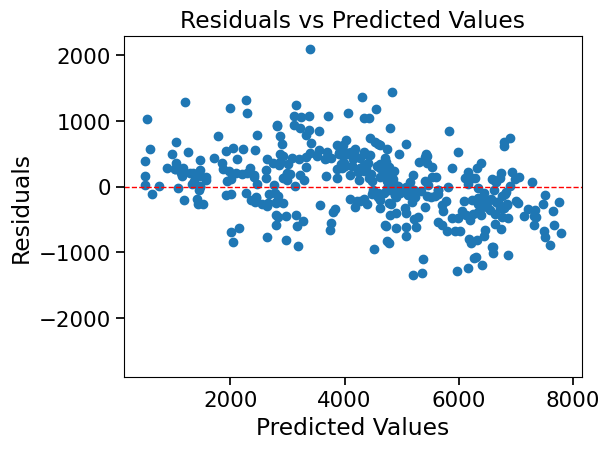

In [28]:
file_name_res_vs_pred_plot = "res_vs_pred_plot.png"
file_path_res_vs_pred_plot = base_path_plots / file_name_res_vs_pred_plot

res_vs_pred_plot = plt.scatter(predicted_mean, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Horizontale Linie bei 0
plt.ylim(-2900, 2300)
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.gcf().savefig(file_path_res_vs_pred_plot)
plt.show()


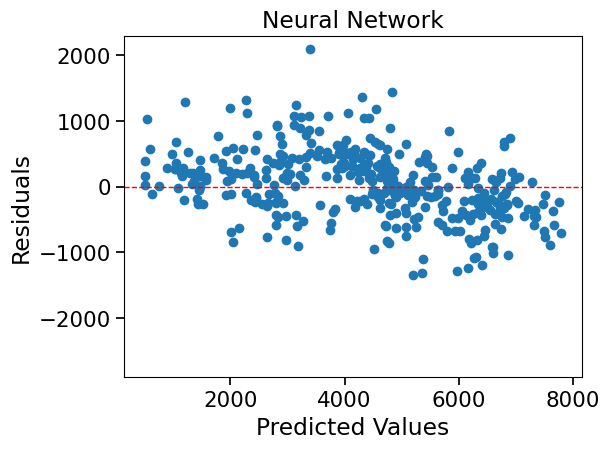

In [30]:
file_name_res_vs_pred_plot = "res_vs_pred_plot_nn.png"
file_path_res_vs_pred_plot = base_path_plots / file_name_res_vs_pred_plot

res_vs_pred_plot = plt.scatter(predicted_mean, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Horizontale Linie bei 0
plt.ylim(-2900, 2300)
plt.title("Neural Network")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.gcf().savefig(file_path_res_vs_pred_plot)
plt.show()

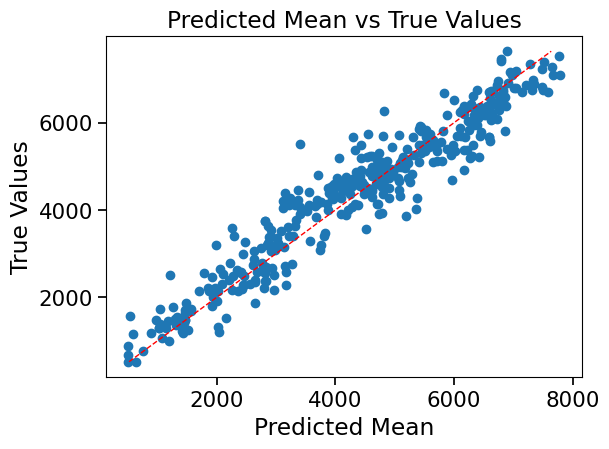

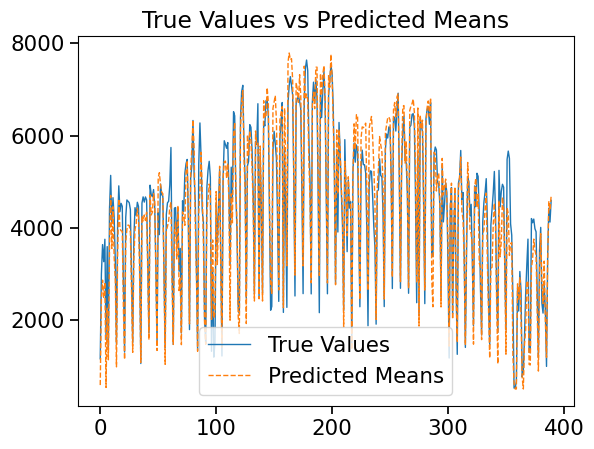

In [70]:
# Scatter plot
plt.scatter(predicted_mean, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Predicted Mean vs True Values")
plt.xlabel("Predicted Mean")
plt.ylabel("True Values")

file_name_scatter_plot = "scatter_plot.png"
file_path_scatter_plot = base_path_plots / file_name_scatter_plot
plt.tight_layout()  
plt.gcf().savefig(file_path_scatter_plot)
plt.show()

# Line plot
plt.plot(y_test, label="True Values")
plt.plot(predicted_mean, label="Predicted Means", linestyle='--')
plt.legend()
plt.title("True Values vs Predicted Means")
plt.show()


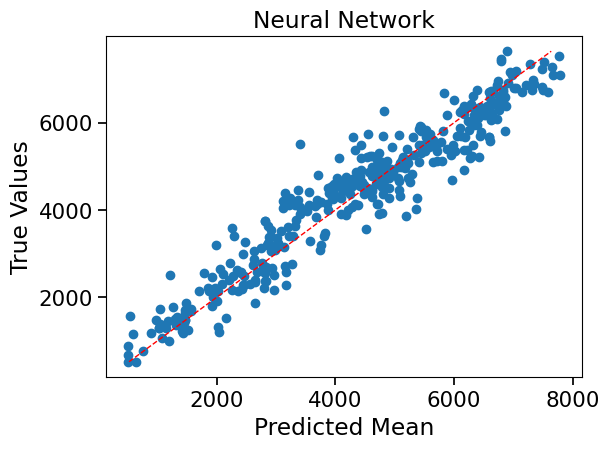

In [71]:
# Scatter plot
plt.scatter(predicted_mean, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Neural Network")
plt.xlabel("Predicted Mean")
plt.ylabel("True Values")

file_name_scatter_plot = "pred_mean_vs_true_values_nn_model_praesi.png"
file_path_scatter_plot = base_path_plots / file_name_scatter_plot
plt.tight_layout()  
plt.gcf().savefig(file_path_scatter_plot)
plt.show()


### Standardized Residuals

In [72]:
standardized_residuals = residuals / predicted_std

standardized_residuals_df = pd.DataFrame(standardized_residuals)

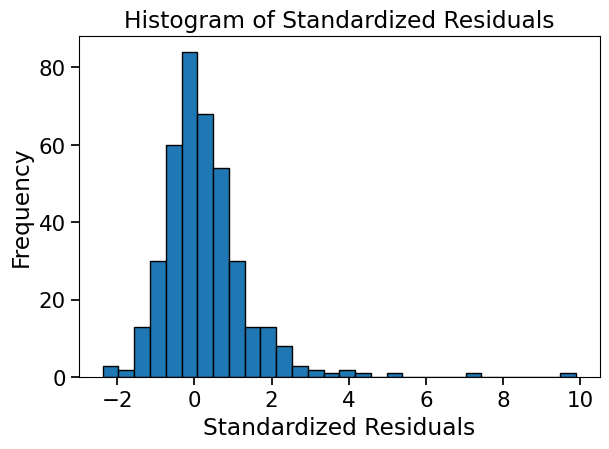

In [137]:
residuals_histogramm = plt.hist(standardized_residuals, bins=30, edgecolor='k', density=False)
plt.title("Histogram of Standardized Residuals")
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency")

plt.tight_layout()
plt.gcf().savefig(base_path_plots / "standardized_residuals_histogramm.png")
plt.show()
plt.close()


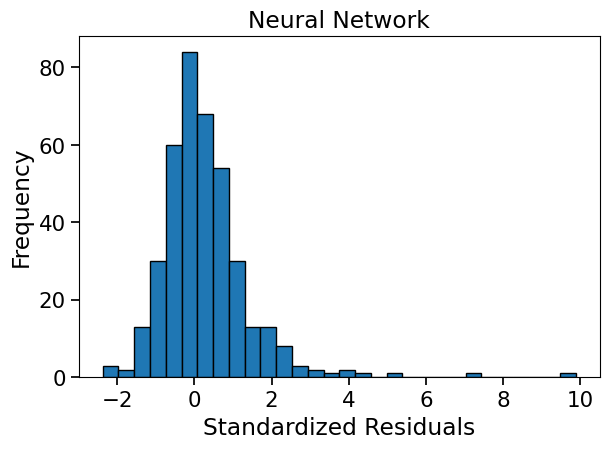

In [74]:
residuals_histogramm = plt.hist(standardized_residuals, bins=30, edgecolor='k', density=False)
plt.title("Neural Network")
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency")

plt.tight_layout()
plt.gcf().savefig(base_path_plots / "standardized_residuals_histogramm_nn.png")
plt.show()
plt.close()

In [75]:
np.mean(residuals)

49.02283124427655

#### Standardized Residuals Outlier Analysis

In [76]:
standardized_residuals_df.describe()

,bike_count
count,390.000000
mean,0.273447
std,1.162897
min,-2.373684
25%,-0.366295
50%,0.101188
75%,0.785741
max,9.885740


In [138]:
standardized_residuals.nlargest(9)

5      9.885740
356    7.231558
0      5.233565
353    4.304035
6      4.040822
365    3.978705
343    3.382966
112    3.129377
367    2.977002
Name: bike_count, dtype: float64

In [78]:
def print_info(index, y_test, predicted_mean, predicted_std, residuals, standardized_residuals, X_test_all):
    print("\033[1mIndex: ", index, "\033[0m")
    print("True Value: ", y_test.iloc[index])
    print("Predicted Mean: ", predicted_mean[index])
    print("Predicted Std: ", predicted_std[index])
    print("Residual: ", residuals[index])
    print("Standardized Residual: ", standardized_residuals[index])
    print("\n\033[1mX_test:\033[0m")
    print(X_test_all.iloc[index])

In [79]:
print_info(5, y_test, predicted_mean, predicted_std, residuals, standardized_residuals, X_test_all)

Index:  5 
True Value:  1574.0
Predicted Mean:  537.50366
Predicted Std:  104.847626
Residual:  1036.496337890625
Standardized Residual:  9.885739716565759

X_test:
date                         2023-01-06 00:00:00
temperature                            -0.243547
humidity                                0.406656
windspeed                               0.943456
wind_direction                          0.702241
visibility                              2.237672
precipitation                          -0.397192
sun                                    -0.932026
windspeed_max                           0.512205
precip_indic                                   0
school_holiday                  weihnachtsferien
school_holiday_indicator                       1
public_holiday              Heilige Drei Koenige
public_holiday_indicator                       1
holiday_indicator                              1
is_workday                                     0
season                                         3
da

In [80]:
print_info(356, y_test, predicted_mean, predicted_std, residuals, standardized_residuals, X_test_all)

Index:  356 
True Value:  2501.0
Predicted Mean:  1214.2354
Predicted Std:  177.9374
Residual:  1286.7646484375
Standardized Residual:  7.2315583890482245

X_test:
date                        2023-12-23 00:00:00
temperature                           -0.459962
humidity                                0.60748
windspeed                              4.140128
wind_direction                         0.904555
visibility                             0.093069
precipitation                          -0.06255
sun                                   -1.094803
windspeed_max                          2.557787
precip_indic                                  1
school_holiday                 weihnachtsferien
school_holiday_indicator                      1
public_holiday                       No Holiday
public_holiday_indicator                      0
holiday_indicator                             1
is_workday                                    0
season                                        3
day_of_week         

In [81]:
print_info(6, y_test, predicted_mean, predicted_std, residuals, standardized_residuals, X_test_all)

Index:  6 
True Value:  3591.0
Predicted Mean:  2266.575
Predicted Std:  327.76132
Residual:  1324.425048828125
Standardized Residual:  4.040821658454595

X_test:
date                        2023-01-07 00:00:00
temperature                           -0.438522
humidity                               0.087822
windspeed                             -0.730211
wind_direction                        -0.123201
visibility                             2.247801
precipitation                         -0.397192
sun                                   -0.284537
windspeed_max                         -0.510587
precip_indic                                  0
school_holiday                 weihnachtsferien
school_holiday_indicator                      1
public_holiday                       No Holiday
public_holiday_indicator                      0
holiday_indicator                             1
is_workday                                    0
season                                        3
day_of_week          

In [82]:
print_info(353, y_test, predicted_mean, predicted_std, residuals, standardized_residuals, X_test_all)

Index:  353 
True Value:  5504.0
Predicted Mean:  3398.9011
Predicted Std:  489.09888
Residual:  2105.098876953125
Standardized Residual:  4.304035392734866

X_test:
date                        2023-12-20 00:00:00
temperature                            -0.82774
humidity                                0.81555
windspeed                              1.910654
wind_direction                         0.716403
visibility                             0.312224
precipitation                          1.250275
sun                                   -0.852447
windspeed_max                          1.534996
precip_indic                                  1
school_holiday                       No Holiday
school_holiday_indicator                      0
public_holiday                       No Holiday
public_holiday_indicator                      0
holiday_indicator                             0
is_workday                                    1
season                                        3
day_of_week       

In [83]:
print_info(0, y_test, predicted_mean, predicted_std, residuals, standardized_residuals, X_test_all)

Index:  0 
True Value:  1160.0
Predicted Mean:  589.4193
Predicted Std:  109.02333
Residual:  570.5806884765625
Standardized Residual:  5.2335650073555415

X_test:
date                        2023-01-01 00:00:00
temperature                            0.156666
humidity                              -0.574689
windspeed                             -0.146301
wind_direction                         0.435186
visibility                             1.740197
precipitation                         -0.397192
sun                                    -0.38582
windspeed_max                          0.154228
precip_indic                                  0
school_holiday                 weihnachtsferien
school_holiday_indicator                      1
public_holiday                          Neujahr
public_holiday_indicator                      1
holiday_indicator                             1
is_workday                                    0
season                                        3
day_of_week         

In [84]:
print_info(112, y_test, predicted_mean, predicted_std, residuals, standardized_residuals, X_test_all)

Index:  112 
True Value:  3200.0
Predicted Mean:  1995.4725
Predicted Std:  384.90964
Residual:  1204.5274658203125
Standardized Residual:  3.1293772579885433

X_test:
date                        2023-04-23 00:00:00
temperature                            0.307662
humidity                               0.079541
windspeed                             -0.196261
wind_direction                         0.588945
visibility                             1.170381
precipitation                          0.297833
sun                                    0.106127
windspeed_max                          1.304868
precip_indic                                  1
school_holiday                       No Holiday
school_holiday_indicator                      0
public_holiday                       No Holiday
public_holiday_indicator                      0
holiday_indicator                             0
is_workday                                    0
season                                        0
day_of_week     

In [85]:
print_info(365, y_test, predicted_mean, predicted_std, residuals, standardized_residuals, X_test_all)

Index:  365 
True Value:  894.0
Predicted Mean:  504.92523
Predicted Std:  97.7893
Residual:  389.07476806640625
Standardized Residual:  3.978704950341484

X_test:
date                        2024-01-01 00:00:00
temperature                           -0.573209
humidity                                -0.2248
windspeed                              2.236176
wind_direction                         0.649639
visibility                             1.281107
precipitation                         -0.397192
sun                                   -0.859681
windspeed_max                          1.688415
precip_indic                                  0
school_holiday                 weihnachtsferien
school_holiday_indicator                      1
public_holiday                          Neujahr
public_holiday_indicator                      1
holiday_indicator                             1
is_workday                                    0
season                                        3
day_of_week         

In [139]:
print_info(367, y_test, predicted_mean, predicted_std, residuals, standardized_residuals, X_test_all)

Index:  367 
True Value:  2553.0
Predicted Mean:  1782.4003
Predicted Std:  258.8509
Residual:  770.5997314453125
Standardized Residual:  2.9770024284292456

X_test:
date                        2024-01-03 00:00:00
temperature                           -0.247212
humidity                               0.222395
windspeed                              3.273631
wind_direction                         0.661778
visibility                             1.745774
precipitation                          2.563101
sun                                   -1.007989
windspeed_max                          2.404369
precip_indic                                  1
school_holiday                 weihnachtsferien
school_holiday_indicator                      1
public_holiday                       No Holiday
public_holiday_indicator                      0
holiday_indicator                             1
is_workday                                    1
season                                        3
day_of_week       

In [86]:
def create_important_info_table(index, y_test, predicted_mean, predicted_std, residuals, standardized_residuals, X_test_all):
    data = {'True Value': [y_test.iloc[index]],
            'Predicted Mean': [predicted_mean[index]],
            'Predicted Std': [predicted_std[index]],
            'Residual': [residuals[index]],
            'Standardized Residual': [standardized_residuals[index]],
            'Index': [index]}
    
    df = pd.DataFrame(data)

    # Select the relevant row from X_test_all
    features = X_test_all[['date', 'temperature', 'windspeed', 'precipitation', 'sun',
                           'school_holiday', 'public_holiday', 'is_workday', 'season',
                           'day_of_week']].iloc[[index]]
    
    features.reset_index(drop=True, inplace=True)
    # Merge the two DataFrames based on the index, keeping all rows from df
    df = df.merge(features, left_index=True, right_index=True, how='left')

    return df


In [87]:
df_5 = create_important_info_table(5, y_test, predicted_mean, predicted_std, residuals, standardized_residuals, X_test_all)

In [88]:
standardized_residuals.nlargest(7)

5      9.885740
356    7.231558
0      5.233565
353    4.304035
6      4.040822
365    3.978705
343    3.382966
Name: bike_count, dtype: float64

In [140]:
index_largest_res = standardized_residuals.nlargest(8).index

In [141]:
all_info = pd.DataFrame()

for i in index_largest_res:
    name = "df_" + str(i)
    name = create_important_info_table(i, y_test, predicted_mean, predicted_std, residuals, standardized_residuals, X_test_all)
    all_info = pd.concat([all_info, name], axis=0)
    all_info = all_info.reset_index(drop=True)

In [142]:
all_info['Predicted Mean'] = all_info['Predicted Mean'].astype('float64')
all_info['Predicted Std'] = all_info['Predicted Std'].astype('float64')

In [143]:
all_info = all_info.round(2)

In [144]:
all_info

,True Value,Predicted Mean,Predicted Std,Residual,Standardized Residual,Index,date,temperature,windspeed,precipitation,sun,school_holiday,public_holiday,is_workday,season,day_of_week
0,1574.0,537.50,104.85,1036.50,9.89,5,2023-01-06,-0.24,0.94,-0.40,-0.93,weihnachtsferien,Heilige Drei Koenige,0,3,4
1,2501.0,1214.24,177.94,1286.76,7.23,356,2023-12-23,-0.46,4.14,-0.06,-1.09,weihnachtsferien,No Holiday,0,3,5
2,1160.0,589.42,109.02,570.58,5.23,0,2023-01-01,0.16,-0.15,-0.40,-0.39,weihnachtsferien,Neujahr,0,3,6
3,5504.0,3398.90,489.10,2105.10,4.30,353,2023-12-20,-0.83,1.91,1.25,-0.85,No Holiday,No Holiday,1,3,2
4,3591.0,2266.57,327.76,1324.43,4.04,6,2023-01-07,-0.44,-0.73,-0.40,-0.28,weihnachtsferien,No Holiday,0,3,5
5,894.0,504.93,97.79,389.07,3.98,365,2024-01-01,-0.57,2.24,-0.40,-0.86,weihnachtsferien,Neujahr,0,3,0
6,1732.0,1048.24,202.12,683.76,3.38,343,2023-12-10,-0.30,2.82,0.56,-1.07,No Holiday,No Holiday,0,3,6
7,3200.0,1995.47,384.91,1204.53,3.13,112,2023-04-23,0.31,-0.20,0.30,0.11,No Holiday,No Holiday,0,0,6


In [145]:
new_order = [ 'Standardized Residual', 'Residual',
   'True Value', 'Predicted Mean', 'Predicted Std', 
    'date', 
    'temperature', 'precipitation', 'season', 'day_of_week', 'is_workday', 'public_holiday', 
    'school_holiday', 'sun', 'windspeed' ]

In [146]:
all_info = all_info[new_order]

In [147]:
all_info

,Standardized Residual,Residual,True Value,Predicted Mean,Predicted Std,date,temperature,precipitation,season,day_of_week,is_workday,public_holiday,school_holiday,sun,windspeed
0,9.89,1036.50,1574.0,537.50,104.85,2023-01-06,-0.24,-0.40,3,4,0,Heilige Drei Koenige,weihnachtsferien,-0.93,0.94
1,7.23,1286.76,2501.0,1214.24,177.94,2023-12-23,-0.46,-0.06,3,5,0,No Holiday,weihnachtsferien,-1.09,4.14
2,5.23,570.58,1160.0,589.42,109.02,2023-01-01,0.16,-0.40,3,6,0,Neujahr,weihnachtsferien,-0.39,-0.15
3,4.30,2105.10,5504.0,3398.90,489.10,2023-12-20,-0.83,1.25,3,2,1,No Holiday,No Holiday,-0.85,1.91
4,4.04,1324.43,3591.0,2266.57,327.76,2023-01-07,-0.44,-0.40,3,5,0,No Holiday,weihnachtsferien,-0.28,-0.73
5,3.98,389.07,894.0,504.93,97.79,2024-01-01,-0.57,-0.40,3,0,0,Neujahr,weihnachtsferien,-0.86,2.24
6,3.38,683.76,1732.0,1048.24,202.12,2023-12-10,-0.30,0.56,3,6,0,No Holiday,No Holiday,-1.07,2.82
7,3.13,1204.53,3200.0,1995.47,384.91,2023-04-23,0.31,0.30,0,6,0,No Holiday,No Holiday,0.11,-0.20


In [148]:
all_info_compacted = all_info.drop(columns=['temperature', 'windspeed', 'precipitation', 'sun'])

In [149]:
all_info_compacted

,Standardized Residual,Residual,True Value,Predicted Mean,Predicted Std,date,season,day_of_week,is_workday,public_holiday,school_holiday
0,9.89,1036.50,1574.0,537.50,104.85,2023-01-06,3,4,0,Heilige Drei Koenige,weihnachtsferien
1,7.23,1286.76,2501.0,1214.24,177.94,2023-12-23,3,5,0,No Holiday,weihnachtsferien
2,5.23,570.58,1160.0,589.42,109.02,2023-01-01,3,6,0,Neujahr,weihnachtsferien
3,4.30,2105.10,5504.0,3398.90,489.10,2023-12-20,3,2,1,No Holiday,No Holiday
4,4.04,1324.43,3591.0,2266.57,327.76,2023-01-07,3,5,0,No Holiday,weihnachtsferien
5,3.98,389.07,894.0,504.93,97.79,2024-01-01,3,0,0,Neujahr,weihnachtsferien
6,3.38,683.76,1732.0,1048.24,202.12,2023-12-10,3,6,0,No Holiday,No Holiday
7,3.13,1204.53,3200.0,1995.47,384.91,2023-04-23,0,6,0,No Holiday,No Holiday


In [150]:
latex_table_compacted = all_info_compacted.to_latex(index=False, float_format="%.2f")

In [151]:
latex_table = all_info.to_latex(index=False, float_format="%.2f")

In [152]:
with open(r"data\standardized_residuals_outliers.tex", 'w') as f:
    f.write(latex_table)

In [153]:
with open(r"data\standardized_residuals_outliers_compacted.tex", 'w') as f:
    f.write(latex_table_compacted)

In [103]:
X_test_all.columns

Index(['date', 'temperature', 'humidity', 'windspeed', 'wind_direction',
       'visibility', 'precipitation', 'sun', 'windspeed_max', 'precip_indic',
       'school_holiday', 'school_holiday_indicator', 'public_holiday',
       'public_holiday_indicator', 'holiday_indicator', 'is_workday', 'season',
       'day_of_week'],
      dtype='object')

In [104]:
X_test_all[['temperature', 'humidity', 'windspeed', 'wind_direction',
       'visibility', 'precipitation', 'sun', 'windspeed_max']].describe()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,0.045667,-0.184861,0.265790,0.025197,0.823301,0.069920,-0.028741,0.311777
std,1.038212,0.971644,1.149807,1.009499,0.915629,0.933852,1.010414,1.070496
min,-2.436286,-2.972153,-1.398428,-2.202990,-1.761707,-0.397192,-1.094803,-1.635657
25%,-0.692915,-0.824166,-0.593601,-0.349793,0.314042,-0.397192,-0.967295,-0.510587
50%,-0.027315,-0.059172,0.018412,0.483741,1.000389,-0.397192,-0.311666,0.154228
75%,0.969002,0.486106,0.855050,0.742704,1.506624,0.085464,0.770799,0.940499
max,2.199509,1.753418,4.140128,1.523636,2.428092,5.600619,2.146262,4.015265


In [105]:
y_test.describe()

count     390.000000
mean     4416.323828
std      1648.149287
min       524.000000
25%      3244.500000
50%      4598.500000
75%      5592.500000
max      7637.000000
Name: bike_count, dtype: float64

### Scores

In [106]:
# Calculate prediction intervals (95% confidence interval)
lower_bound = predicted_mean - 1.96 * predicted_std
upper_bound = predicted_mean + 1.96 * predicted_std

# Check how many actual values fall within the prediction interval
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))

print(f"PICP (Prediction Interval Coverage Probability): {coverage:.2f}")

#picp represents the percentage of actual values that fall within the prediction interval
#94 percent of true values fall within 95% of the prediction interval

PICP (Prediction Interval Coverage Probability): 0.93


In [107]:
def calculate_mse(y_pred, y_true):
    mse = np.mean((y_true - y_pred) ** 2)
    print(f'Mean MSE: {mse}')
    return mse

def calculate_rmse(y_pred, y_true):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    print(f'Mean RMSE: {rmse}')
    return rmse

In [108]:
mse = calculate_mse(predicted_mean, y_test)
rmse = calculate_rmse(predicted_mean, y_test)

Mean MSE: 265272.65019470063
Mean RMSE: 515.046260247272


In [109]:
mean_std = np.mean(predicted_std)

spread_skill_ratio = mean_std / rmse

print(f"Spread Skill Ratio: {spread_skill_ratio:.2f}")

Spread Skill Ratio: 1.24


### PIT - Histogram

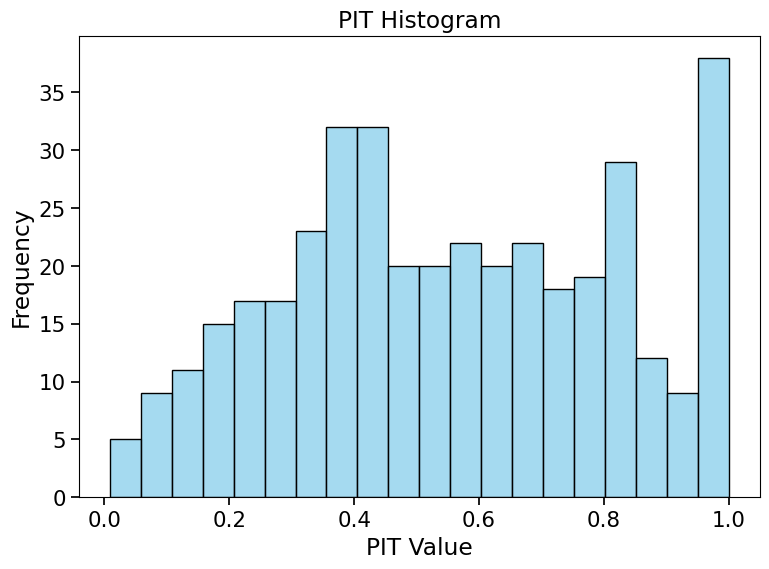

In [110]:
pit_values = norm.cdf(y_test, loc=predicted_mean, scale=predicted_std)

plt.figure(figsize=(8, 6))
sns.histplot(pit_values, bins=20, kde=False, stat='count', edgecolor='k', color='skyblue')
plt.title('PIT Histogram')
plt.xlabel('PIT Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.gcf().savefig(base_path_plots / "PIT_Histogram_frequency.png")
plt.show()



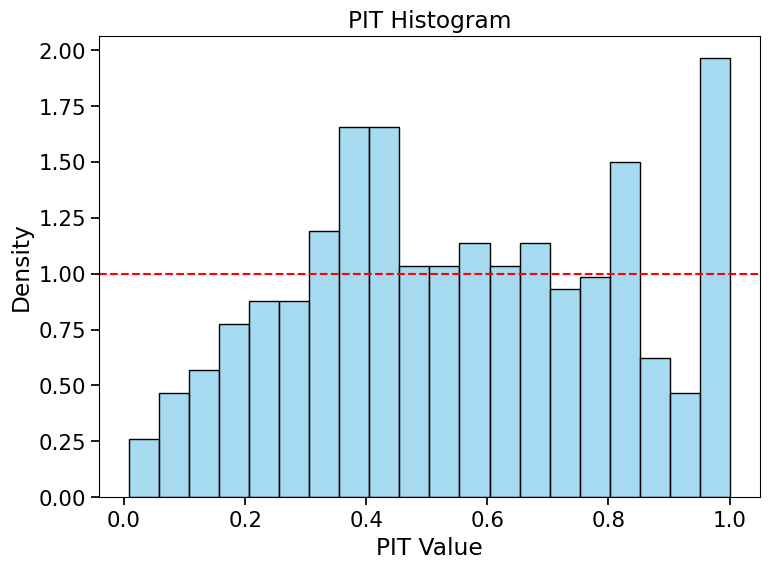

In [111]:
pit_values = norm.cdf(y_test, loc=predicted_mean, scale=predicted_std)

plt.figure(figsize=(8, 6))
sns.histplot(pit_values, bins=20, kde=False, stat='density', edgecolor='k', color='skyblue')
plt.axhline(1, color='red', linestyle='--', linewidth=1.5, label='Density = 1')
plt.title('PIT Histogram')
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.tight_layout()
plt.gcf().savefig(base_path_plots / "PIT_Histogram.png")
plt.show()


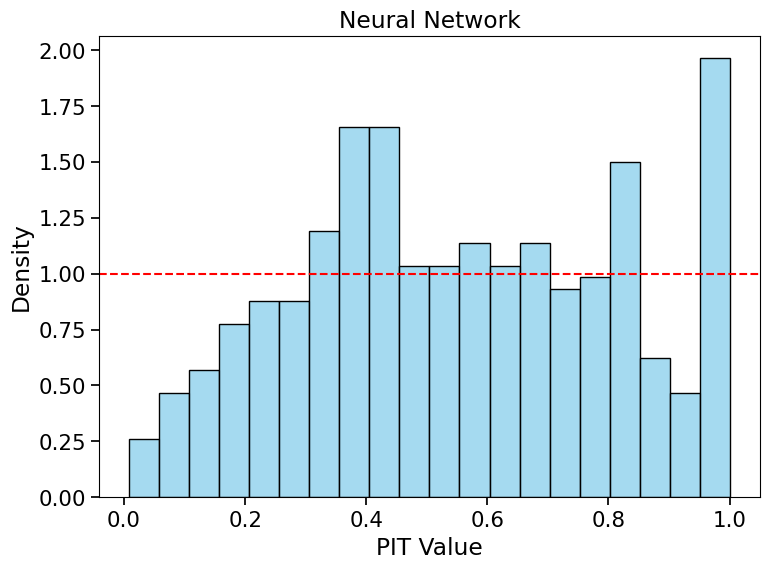

In [112]:
pit_values = norm.cdf(y_test, loc=predicted_mean, scale=predicted_std)

plt.figure(figsize=(8, 6))
sns.histplot(pit_values, bins=20, kde=False, stat='density', edgecolor='k', color='skyblue')
plt.axhline(1, color='red', linestyle='--', linewidth=1.5, label='Density = 1')
plt.title('Neural Network')
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.tight_layout()
plt.gcf().savefig(base_path_plots / "PIT_Histogram_nn.png")
plt.show()

### Hyperparameter Impact

In [113]:
cv_results_df = pd.DataFrame(loaded_grid_search_tuned.cv_results_)

In [114]:
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_batch_size', 'param_model__dropout_rate',
       'param_model__n_blocks', 'param_model__n_neurons',
       'param_model__reg_value', 'param_optimizer__learning_rate', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [115]:
df_cv_scores = pd.DataFrame(loaded_grid_search_tuned.cv_results_)[['mean_test_score', 'std_test_score']]

In [116]:
df_cv_scores

,mean_test_score,std_test_score
0,-426.810343,36.226054
1,-398.709676,35.978732
2,-433.141602,51.849570
3,-440.048940,64.275419


In [117]:
df_cv_scores_not_negated = df_cv_scores.copy()
df_cv_scores_not_negated['mean_test_score'] = df_cv_scores_not_negated['mean_test_score'] * -1


In [118]:
df_cv_scores_not_negated

,mean_test_score,std_test_score
0,426.810343,36.226054
1,398.709676,35.978732
2,433.141602,51.849570
3,440.048940,64.275419


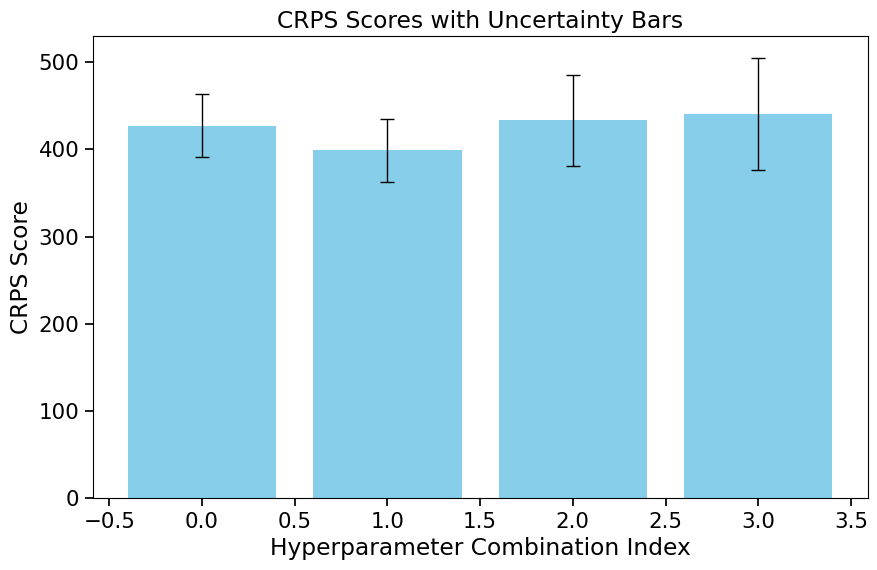

In [119]:
# Plotting with uncertainty bars
plt.figure(figsize=(10, 6))
plt.bar(df_cv_scores_not_negated.index, df_cv_scores_not_negated['mean_test_score'], 
        yerr=df_cv_scores_not_negated['std_test_score'], capsize=5, color='skyblue')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('CRPS Score')
plt.title('CRPS Scores with Uncertainty Bars')
plt.show()


In [120]:
df_cv_scores

,mean_test_score,std_test_score
0,-426.810343,36.226054
1,-398.709676,35.978732
2,-433.141602,51.849570
3,-440.048940,64.275419


In [121]:
loaded_grid_search_tuned.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=KerasRegressor(epochs=200, model=<function tune_nn.<locals>.create_model at 0x000001C1480C2160>, verbose=0),
             n_jobs=1,
             param_grid={'batch_size': [32], 'model__dropout_rate': [0.25],
                         'model__n_blocks': [2, 4, 5, 6],
                         'model__n_neurons': [256], 'model__reg_value': [0.01],
                         'optimizer__learning_rate': [0.0001]},
             scoring=make_scorer(crps_loss_function_wrapper, greater_is_better=False, response_method='predict'),
             verbose=10)>

In [122]:
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_model__dropout_rate,param_model__n_blocks,param_model__n_neurons,param_model__reg_value,param_optimizer__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,78.204610,18.691333,0.313856,0.110598,32,0.25,2,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-433.170929,-379.605652,-467.654449,-426.810343,36.226054,2
1,82.485094,0.595056,0.311036,0.040606,32,0.25,4,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-388.475555,-360.662506,-446.990967,-398.709676,35.978732,1
2,92.725573,0.280839,0.355519,0.040057,32,0.25,5,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-430.640564,-370.926575,-497.857666,-433.141602,51.849570,3
3,102.334637,0.126687,0.345651,0.015663,32,0.25,6,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-416.934509,-375.472809,-527.739502,-440.048940,64.275419,4


In [123]:
cv_results_df['mean_test_score'] = cv_results_df['mean_test_score'] * -1

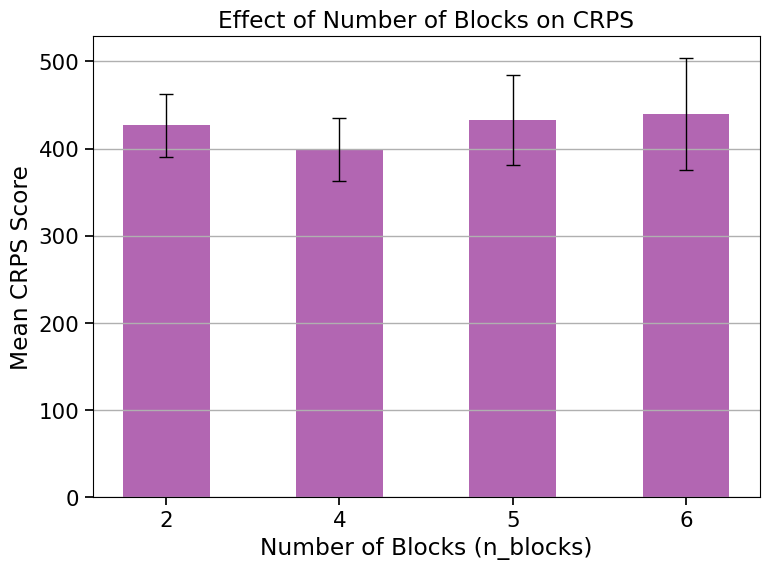

In [124]:
n_blocks_values = cv_results_df['param_model__n_blocks'].unique()
mean_crps_n_blocks = [cv_results_df[cv_results_df['param_model__n_blocks'] == nb]['mean_test_score'].mean() for nb in n_blocks_values]
std_crps_n_blocks = [cv_results_df[cv_results_df['param_model__n_blocks'] == nb]['std_test_score'].mean() for nb in n_blocks_values]

bar_width = 0.4  
index = np.arange(len(n_blocks_values))  *0.8
plt.figure(figsize=(8, 6))
plt.bar(index, mean_crps_n_blocks, yerr=std_crps_n_blocks, capsize=5, color='purple', alpha=0.6, width=bar_width, label="n_blocks")

plt.title("Effect of Number of Blocks on CRPS")
plt.xlabel("Number of Blocks (n_blocks)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, n_blocks_values)  
plt.grid(True, axis='y')
plt.tight_layout()
plt.gcf().savefig(base_path_plots / "n_blocks_effect.png")
plt.show()


In [125]:
mean_crps_n_blocks

[426.8103434244792, 398.7096761067708, 433.1416015625, 440.04894002278644]

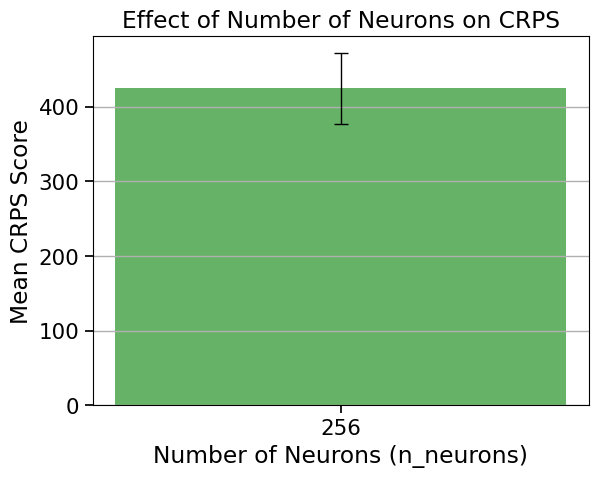

In [126]:
n_neurons_values = cv_results_df['param_model__n_neurons'].unique()
mean_crps_n_neurons = [cv_results_df[cv_results_df['param_model__n_neurons'] == nn]['mean_test_score'].mean() for nn in n_neurons_values]
std_crps_n_neurons = [cv_results_df[cv_results_df['param_model__n_neurons'] == nn]['std_test_score'].mean() for nn in n_neurons_values]


bar_width = 0.18 
index = np.arange(len(n_neurons_values)) *0.3

plt.bar(index, mean_crps_n_neurons, yerr=std_crps_n_neurons, capsize=5, color='green', alpha=0.6, width=bar_width, label="n_neurons")

plt.title("Effect of Number of Neurons on CRPS")
plt.xlabel("Number of Neurons (n_neurons)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, n_neurons_values) 
plt.grid(True, axis='y')
plt.gcf().savefig(base_path_plots / "n_neurons_effect.png")
plt.show()

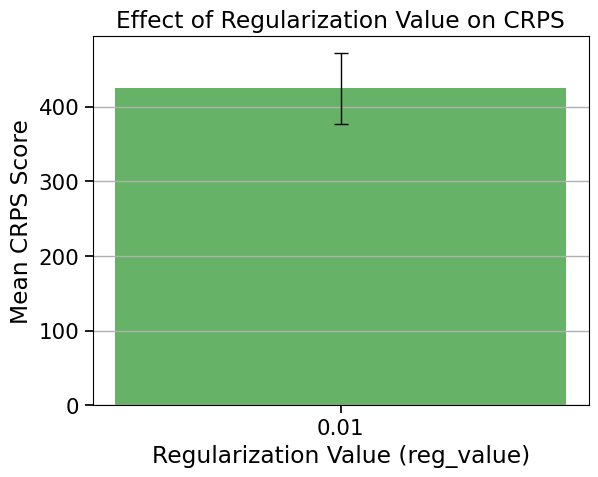

In [127]:
reg_value_values = cv_results_df['param_model__reg_value'].unique()
mean_crps_reg_value = [cv_results_df[cv_results_df['param_model__reg_value'] == rv]['mean_test_score'].mean() for rv in reg_value_values]
std_crps_reg_value = [cv_results_df[cv_results_df['param_model__reg_value'] == rv]['std_test_score'].mean() for rv in reg_value_values]

bar_width = 0.18
index = np.arange(len(reg_value_values))*0.3

plt.bar(index, mean_crps_reg_value, yerr=std_crps_reg_value, capsize=5, color='green', alpha=0.6, width=bar_width, label="reg_value")

plt.title("Effect of Regularization Value on CRPS")
plt.xlabel("Regularization Value (reg_value)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, reg_value_values)
plt.grid(True, axis='y')
plt.gcf().savefig(base_path_plots / "reg_value_effect.png")
plt.show()

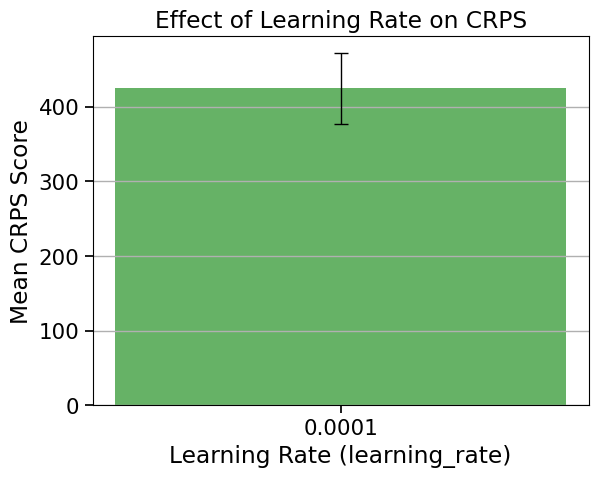

In [128]:
learning_rate_values = cv_results_df['param_optimizer__learning_rate'].unique()
mean_crps_learning_rate = [cv_results_df[cv_results_df['param_optimizer__learning_rate'] == lr]['mean_test_score'].mean() for lr in learning_rate_values]
std_crps_learning_rate = [cv_results_df[cv_results_df['param_optimizer__learning_rate'] == lr]['std_test_score'].mean() for lr in learning_rate_values]

bar_width = 0.18
index = np.arange(len(learning_rate_values)) * 0.3


plt.bar(index, mean_crps_learning_rate, yerr=std_crps_learning_rate, capsize=5, color='green', alpha=0.6, width=bar_width, label="learning_rate")
plt.title("Effect of Learning Rate on CRPS")
plt.xlabel("Learning Rate (learning_rate)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, learning_rate_values)
plt.grid(True, axis='y')
plt.gcf().savefig(base_path_plots / "learning_rate_effect.png")
plt.show()

In [129]:
loaded_grid_search_tuned.best_params_

{'batch_size': 32,
 'model__dropout_rate': 0.25,
 'model__n_blocks': 4,
 'model__n_neurons': 256,
 'model__reg_value': 0.01,
 'optimizer__learning_rate': 0.0001}

In [130]:
model.model_.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_134 (Dense)               │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,656 (2.30 MB)

 Trainable params: 201,218 (786.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 402,438 (1.54 MB)

In [131]:
mean_crps = predict_and_calculate_mean_crps(model.model_, X_test, y_test, print_predicted_mean_std = False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Mean CRPS: 302.85038590421107


In [132]:
loaded_grid_search_tuned.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=KerasRegressor(epochs=200, model=<function tune_nn.<locals>.create_model at 0x000001C1480C2160>, verbose=0),
             n_jobs=1,
             param_grid={'batch_size': [32], 'model__dropout_rate': [0.25],
                         'model__n_blocks': [2, 4, 5, 6],
                         'model__n_neurons': [256], 'model__reg_value': [0.01],
                         'optimizer__learning_rate': [0.0001]},
             scoring=make_scorer(crps_loss_function_wrapper, greater_is_better=False, response_method='predict'),
             verbose=10)>

### Other

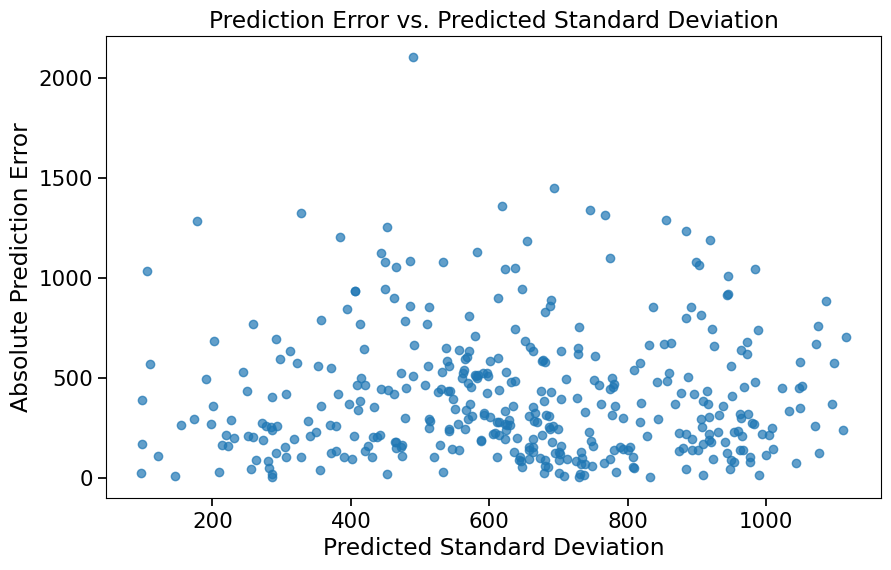

Correlation between predicted std and errors: 0.00


In [133]:
errors = np.abs(y_test - predicted_mean)

# Plot errors vs predicted standard deviations
plt.figure(figsize=(10, 6))
plt.scatter(predicted_std, errors, alpha=0.7)
plt.xlabel("Predicted Standard Deviation")
plt.ylabel("Absolute Prediction Error")
plt.title("Prediction Error vs. Predicted Standard Deviation")
plt.show()

# Calculate correlation coefficient
correlation = np.corrcoef(predicted_std, errors)[0, 1]
print(f"Correlation between predicted std and errors: {correlation:.2f}")

p-value: 0.9773668181526856


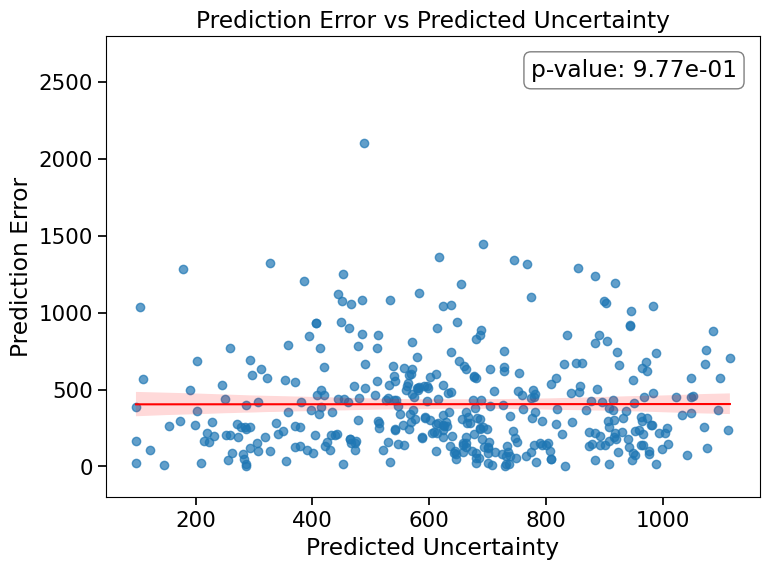

In [134]:
this_plot = plt.figure(figsize=(8, 6))
# Scatter plot
plt.scatter(predicted_std, errors, alpha=0.7)


sns.regplot( x=predicted_std, y=errors, scatter=False, color='red')

plt.xlabel("Predicted Uncertainty")
plt.ylabel("Prediction Error")
plt.title("Prediction Error vs Predicted Uncertainty")
# Calculate the p-value for the regression
slope, intercept, r_value, p_value, std_err = stats.linregress(predicted_std, errors)
print(f'p-value: {p_value}')
plt.ylim(-200, 2800)
# Add the p-value to the plot
plt.text(0.65, 0.95, f'p-value: {p_value:.2e}', transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.tight_layout()
plt.gcf().savefig(base_path_plots / "prediction_error_vs_predicted_uncertainty.png")
# Show plot
plt.show()

p-value: 0.9773668181526856


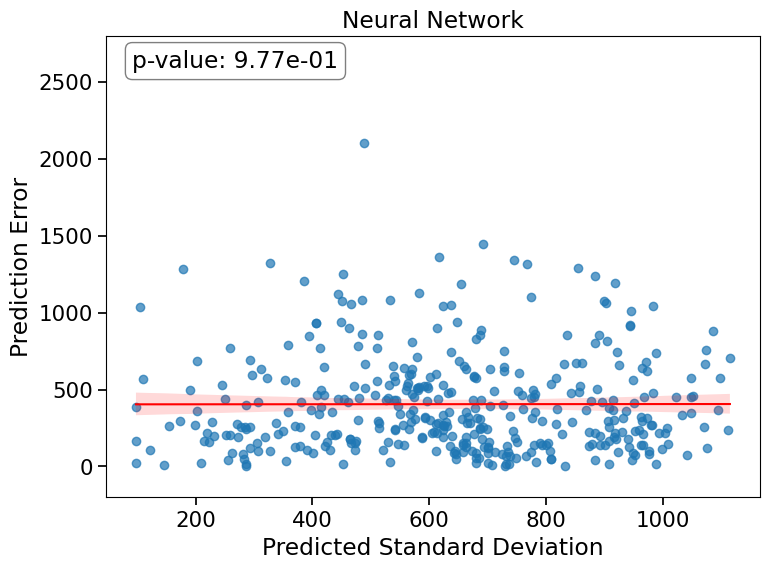

In [135]:
this_plot = plt.figure(figsize=(8, 6))
# Scatter plot
plt.scatter(predicted_std, errors, alpha=0.7)


sns.regplot( x=predicted_std, y=errors, scatter=False, color='red')

plt.xlabel("Predicted Standard Deviation")
plt.ylabel("Prediction Error")
plt.title("Neural Network")
plt.ylim(-200, 2800)

# Calculate the p-value for the regression
slope, intercept, r_value, p_value, std_err = stats.linregress(predicted_std, errors)
print(f'p-value: {p_value}')
plt.ylim(-200, 2800)
# Add the p-value to the plot
plt.text(0.04, 0.97, f'p-value: {p_value:.2e}', transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.tight_layout()
plt.gcf().savefig(base_path_plots / "prediction_error_vs_predicted_uncertainty_nn.png")
# Show plot
plt.show()

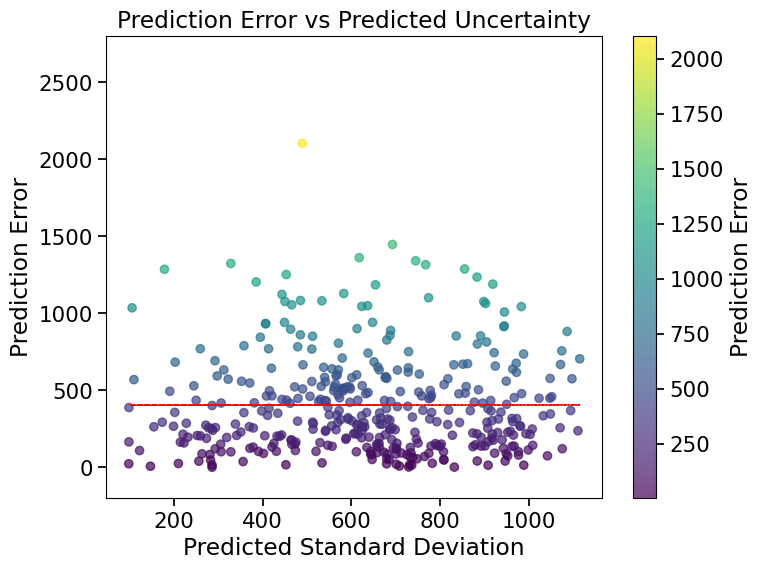

In [136]:
plt.figure(figsize=(8, 6))
# Calculate and plot trendline
z = np.polyfit(predicted_std, errors, 1)  # Linear fit
p = np.poly1d(z)
plt.ylim(-200, 2800)
plt.plot(predicted_std, p(predicted_std), color="red", linestyle="--")
plt.scatter(predicted_std, errors, c=errors, cmap='viridis', alpha=0.7)
plt.xlabel("Predicted Standard Deviation")
plt.ylabel("Prediction Error")
plt.title("Prediction Error vs Predicted Uncertainty")
plt.colorbar(label="Prediction Error")
plt.gcf().savefig(base_path_plots / "prediction_error_vs_predicted_uncertainty_colored.png")
plt.show()